In [1]:
import numpy as np
import pandas as pd

In [50]:
%config InlineBackend.figure_format ='retina'
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
# import seaborn as sns

In [4]:
# 设为白色网格背景
# sns.set(font='Hiragino Sans GB', style='ticks', context='notebook', palette='deep')

# SMALL_SIZE = 8
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 12

# plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
# sns.palplot(sns.color_palette("muted"))

In [5]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cab

In [7]:
df = pd.read_csv('d:/datasets/train_nitration_941_standard.csv')
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values - 1
print(df.shape)

(212, 942)


In [8]:
f_name = df.columns[1:].values
t_name = df.iloc[:, 0].unique()

In [9]:
# 替换评估方法
from sklearn.metrics import make_scorer, accuracy_score, matthews_corrcoef, confusion_matrix, classification_report

In [73]:
scoring = {'MCC': make_scorer(matthews_corrcoef),
           'ACC': make_scorer(accuracy_score)}

In [76]:
result_gdbt_mcc = cross_val_score(clf_gdbt, X, y, cv=5, verbose=1, n_jobs=-1, scoring=scoring['MCC'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.4s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished


In [77]:
print(result_gdbt_mcc)

[0.11987084 0.04865618 0.25787778 0.1375     0.49470885]


## ROC and AUC Learning

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.utils import shuffle

In [18]:
clf_gdbt_roc = GradientBoostingClassifier(n_estimators=100, verbose=1)

In [19]:
X_gdbt, y_gdbt = shuffle(X, y, random_state=0)

In [20]:
# 预测各个样本的概率
y_pred_gdbt_prob = cross_val_predict(
    clf_gdbt_roc, X_gdbt, y_gdbt, cv=10, n_jobs=-1, verbose=1, method='predict_proba')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:   13.6s remaining:   20.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.2s finished


In [21]:
# First column is positive sample, the other is negative
y_pred_gdbt_prob[0:3]

array([[0.10162666, 0.89837334],
       [0.10024323, 0.89975677],
       [0.00826417, 0.99173583]])

In [26]:
y_pred_gdbt = np.argmax(y_pred_gdbt_prob, axis=1)+1

In [28]:
# GDBT MCC Value
matthews_corrcoef(y_gdbt, y_pred_gdbt)

0.5207137414689238

In [39]:
# 计算 FPR 和 TPR
fpr_gdbt, tpr_gdbt, thresholds_gdbt = roc_curve(y_gdbt-1, y_pred_gdbt_prob[:, 1])

In [40]:
auc_gdbt = auc(fpr_gdbt, tpr_gdbt)

In [41]:
auc_gdbt

0.8246878715814507

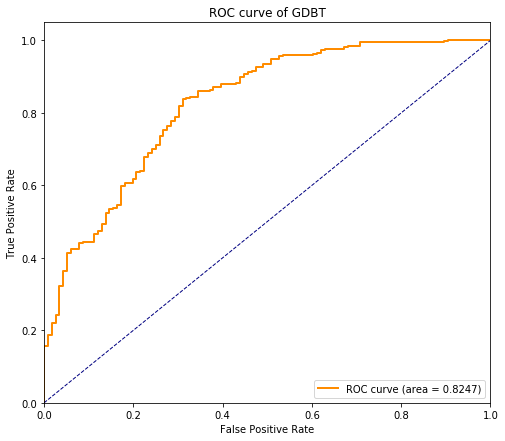

In [44]:
plt.figure(figsize=(8, 7))
plt.plot(fpr_gdbt, tpr_gdbt, color='darkorange', lw=2,
         label='ROC curve (area = %0.4f)' % auc_gdbt)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of GDBT')
plt.legend(loc="lower right")
plt.show()

## 使用 sklearn.model_selection.cross_val_predict

In [221]:
from sklearn.svm import SVC

In [229]:
np.unique(y, return_counts=True)

(array([1, 2]), array([ 53, 159]))

In [46]:
# 交叉验证
rs = KFold(n_splits=10, shuffle=True, random_state=0)

In [47]:
# 生成 k-fold 训练集、测试集索引
cv_index_set = rs.split(y)
k_fold_step = 1  # 初始化折数
# 暂存每次选中的测试集和对应预测结果
test_cache = pred_cache = np.array([], dtype=np.int)

In [48]:
clf_lgb = lgb.LGBMClassifier(n_estimators=100, n_jobs=-1)

In [ ]:
# 迭代训练 k-fold 交叉验证
for train_index, test_index in cv_index_set:
    print("\nFold:", k_fold_step)
    clf_lgb.fit(X[train_index], y[train_index])
    # 测试集验证
    y_pred = clf_lgb.predict(X[test_index])
    # 计算测试集 ACC
    accTest = accuracy_score(y[test_index], y_pred)
    print("\nFold:", k_fold_step, "Test Accuracy:",
          "{:.6f}".format(accTest), "Test Size:", test_index.size)
    # 暂存每次选中的测试集和预测结果
    test_cache = np.concatenate((test_cache, y[test_index]))
    pred_cache = np.concatenate((pred_cache, y_pred))
    print("\n=========================================================================")
    # 每个fold训练结束后次数 +1
    k_fold_step += 1

In [50]:
# LGB 941-dim MCC
matthews_corrcoef(test_cache, pred_cache)

0.5149916547369918

In [51]:
# 压缩维度
X_compress = df.iloc[:, 1:201].values

In [52]:
X_compress.shape

(464, 200)

In [55]:
X_lgb, y_lgb = shuffle(X_compress, y, random_state=0)

In [56]:
clf_compress_lgb = lgb.LGBMClassifier(n_estimators=100, n_jobs=-1)

In [57]:
y_pred_lgb = cross_val_predict(clf_compress_lgb, X_lgb, y_lgb, cv=10, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:   14.0s remaining:   21.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.3s finished


In [58]:
# LGB 200-dim MCC
matthews_corrcoef(y_lgb, y_pred_lgb)

0.5492870101164935

### 基于树的特征提取

In [11]:
from sklearn.feature_selection import SelectFromModel

In [12]:
clf_cat = cab.CatBoostClassifier(n_estimators=100)

In [13]:
X_new, y_new = shuffle(X, y, random_state=0)

In [14]:
clf_cat.fit(X_new, y_new)

Learning rate set to 0.084038
0:	learn: 0.6608413	total: 142ms	remaining: 14s
1:	learn: 0.6068198	total: 174ms	remaining: 8.52s
2:	learn: 0.5815830	total: 212ms	remaining: 6.86s
3:	learn: 0.5441654	total: 246ms	remaining: 5.9s
4:	learn: 0.5147660	total: 280ms	remaining: 5.32s
5:	learn: 0.4906148	total: 313ms	remaining: 4.91s
6:	learn: 0.4705026	total: 346ms	remaining: 4.59s
7:	learn: 0.4597084	total: 377ms	remaining: 4.33s
8:	learn: 0.4377200	total: 409ms	remaining: 4.13s
9:	learn: 0.4233981	total: 449ms	remaining: 4.04s
10:	learn: 0.4049869	total: 483ms	remaining: 3.91s
11:	learn: 0.3870323	total: 516ms	remaining: 3.78s
12:	learn: 0.3721907	total: 548ms	remaining: 3.66s
13:	learn: 0.3582601	total: 580ms	remaining: 3.56s
14:	learn: 0.3482028	total: 617ms	remaining: 3.5s
15:	learn: 0.3346284	total: 650ms	remaining: 3.41s
16:	learn: 0.3247020	total: 684ms	remaining: 3.34s
17:	learn: 0.3135249	total: 717ms	remaining: 3.26s
18:	learn: 0.2995123	total: 749ms	remaining: 3.19s
19:	learn: 0.29

In [15]:
model_cat = SelectFromModel(clf_cat, prefit=True)

In [16]:
# 查看压缩后的特征矩阵
X_cat = model_cat.transform(X_new)

In [17]:
X_cat.shape

(212, 232)

In [97]:
# support_features_idxs = np.where(model_cat.get_support()==True)

In [118]:
# 获取重要特征的排序（降序）
f_idxs = np.argsort(-clf_cat.feature_importances_)[0:232]

In [122]:
clf_cat.feature_importances_[f_idxs[0:10]]

array([1.61941749, 1.57942274, 1.50865342, 1.48927832, 1.41542718,
       1.19001169, 1.16874731, 1.10048441, 1.03538579, 1.01300739])

In [125]:
# 获取对应的特征名称
f_name[f_idxs[0:10]]

array(['Site14_AA_Factor_1', 'Site20_PSSM_S', 'Site15_AA_Factor_2',
       'Site2_PSSM_I', 'Site5_PSSM_V', 'Site12_AA_Factor_2',
       'Site20_PSSM_T', 'Site2_PSSM_L', 'Site13_AA_Factor_1',
       'Site14_PSSM_S'], dtype=object)

In [127]:
np.where(f_name=='Site14_AA_Factor_1')

(array([906], dtype=int64),)

In [128]:
f_idxs

array([906, 416, 912,  50, 120, 897, 417,  51, 901, 296,  25,  21, 220,
         9, 273,   7, 145, 320, 386, 258, 124, 251, 311, 852, 732, 305,
       233,  54,  99, 314, 252, 875, 933,  60,  11, 403, 284, 206,  10,
       347, 411, 881, 232, 853, 224, 916, 846, 938, 862, 414, 157, 304,
       412, 217,   1,  22, 914, 892, 306, 868, 857, 333, 122, 313, 297,
       221, 407, 216,  14, 882, 878,   4, 166, 288, 134, 309, 186, 927,
       342, 886, 324, 163, 162, 290, 137, 876, 184, 920, 866, 182, 156,
       125, 435, 385, 272,  37, 903, 880, 335, 105, 321,   0,  13, 187,
       430, 155, 119, 128, 905, 352, 209,   6, 123, 265, 400, 275, 383,
       408, 353, 293, 312, 299,  31, 334,   5, 529, 294, 194, 141, 133,
       629,  44, 242,  33, 869, 936, 260, 889,  27, 888, 197, 374,  24,
       341, 111, 234, 391, 161,  77, 937, 854, 268, 240, 861, 109,  55,
       370,  94, 214, 180, 301,  20, 228, 349,  78, 256, 316, 363, 535,
       402, 917, 883, 254, 921,  48,  86, 388, 555, 201, 295, 40

### 网格搜索最佳参数

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, matthews_corrcoef, classification_report, make_scorer

In [19]:
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [26]:
# 树模型的参数选择
parameters = {'random_state':np.arange(100, 200)}
parameters_lgb = {'random_state':np.arange(1, 100)}

In [27]:
# RF and ExtraTrees
clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf_ext = ExtraTreesClassifier(n_estimators=100, n_jobs=-1)

In [28]:
clf_grid_rf = GridSearchCV(clf_rf, parameters, cv=10, iid=False, scoring=make_scorer(matthews_corrcoef), n_jobs=-1, verbose=1)

In [29]:
%%time
# 以降维后特征矩阵为例, 10 fold
clf_grid_rf.fit(X_cat, y_new)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   59.5s


Wall time: 1min 14s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.2min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,...
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 16

In [30]:
clf_grid_rf.best_params_

{'random_state': 173}

In [31]:
clf_grid_rf.best_score_

0.4094793512877339

In [32]:
from sklearn.model_selection import cross_val_predict

In [33]:
%%time
# 采用最佳参数进行 CV 验证
clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_features='sqrt', random_state=173)
y_pred_rf = cross_val_predict(clf_rf, X_cat, y_new, cv=10, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Wall time: 886 ms


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.8s finished


In [35]:
matthews_corrcoef(y_new, y_pred_rf)

0.45363235436327737

In [36]:
# 极限树
clf_grid_ext = GridSearchCV(clf_ext, parameters, cv=10, iid=False, scoring=make_scorer(matthews_corrcoef), n_jobs=-1, verbose=1)

In [37]:
%%time
clf_grid_ext.fit(X_cat, y_new)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   57.5s


Wall time: 1min 12s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.2min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None,
                                            criterion='gini', max_depth=None,
                                            max_features='auto',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            oob_score=False, r...
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 1

In [38]:
clf_grid_ext.best_params_

{'random_state': 113}

In [39]:
clf_grid_ext.best_score_

0.40122413988915306

In [40]:
%%time
# 采用最佳参数进行 CV 验证
clf_ext = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, max_features='sqrt', random_state=113)
y_pred_ext = cross_val_predict(clf_ext, X_cat, y_new, cv=10, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Wall time: 845 ms


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


In [41]:
matthews_corrcoef(y_new, y_pred_ext)

0.4605661864718383

In [99]:
# LightGBM 数据
clf_lgb = lgb.LGBMClassifier(boosting_type='goss', n_estimators=100, n_jobs=-1)

In [100]:
# LGB
clf_grid_lgb = GridSearchCV(clf_lgb, parameters_lgb, cv=10, iid=False, scoring=make_scorer(matthews_corrcoef), n_jobs=-1, verbose=1)

In [101]:
# 尝试更低维度
X_lgb = X_cat[:, 0:100]

In [102]:
%%time
clf_grid_lgb.fit(X_lgb, y)

Fitting 10 folds for each of 99 candidates, totalling 990 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:    5.1s


CPU times: user 5.76 s, sys: 291 ms, total: 6.05 s
Wall time: 6.65 s


[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:    6.5s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='goss', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lamb...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79

In [103]:
clf_grid_lgb.best_params_

{'random_state': 60}

In [104]:
clf_grid_lgb.best_score_

0.5628205331759414

In [105]:
%%time
# 采用最佳参数进行 CV 验证
clf_lgb = lgb.LGBMClassifier(boosting_type='goss', n_estimators=100, n_jobs=-1, random_state=60)
y_pred_lgb = cross_val_predict(clf_lgb, X_lgb, y, cv=10, n_jobs=-1, verbose=1)

CPU times: user 56.6 ms, sys: 8.06 ms, total: 64.6 ms
Wall time: 166 ms


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [106]:
matthews_corrcoef(y, y_pred_lgb)

0.5648407167233819

### 树模型 IFS 增量特征选择

In [44]:
y_pred_lgb_list = list()

In [45]:
%%time
# IFS curve
clf_lgb = lgb.LGBMClassifier(boosting_type='goss', n_estimators=100, n_jobs=-1, random_state=0)
for i in range(0, X_cat.shape[1]):
    y_pred_lgb_list.append(cross_val_predict(clf_lgb, X_cat[:, 0:i+1], y_new, cv=10, n_jobs=-1))

Wall time: 31.6 s


In [57]:
mcc_lgb = list()

In [58]:
for i in range(0, X_cat.shape[1]):
    mcc_lgb.append(matthews_corrcoef(y_new, y_pred_lgb_list[i]))

In [59]:
x_ = np.linspace(1, X_cat.shape[1], X_cat.shape[1])

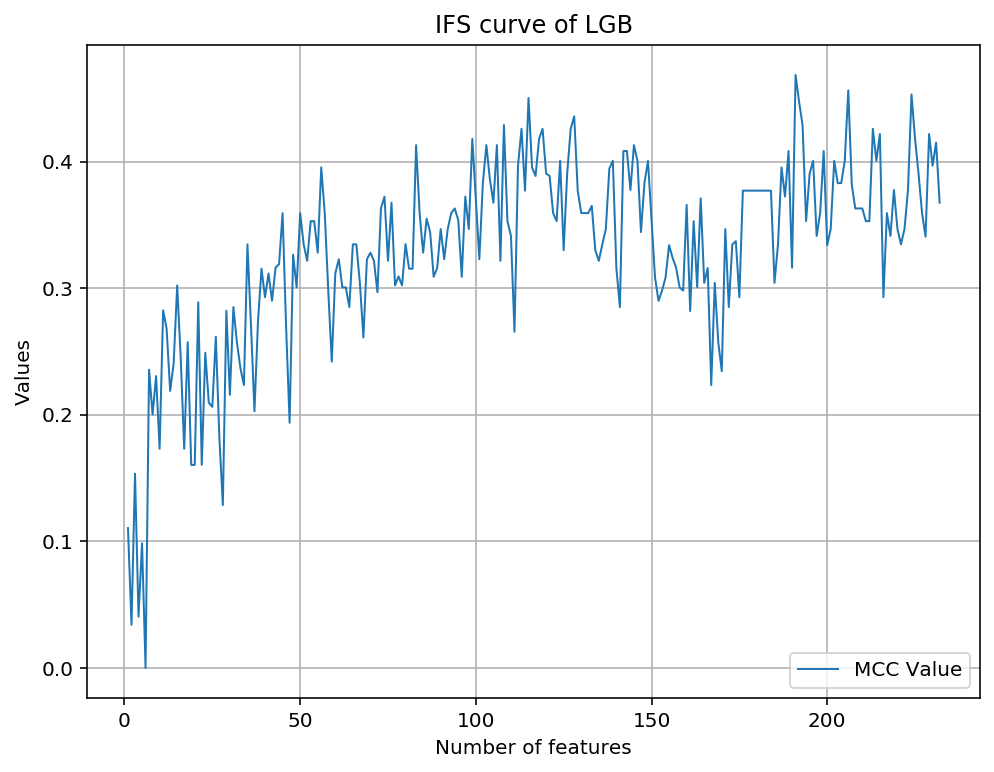

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(x_, mcc_lgb, label='MCC Value', lw=1)
plt.xlabel('Number of features')
plt.ylabel('Values')
plt.title('IFS curve of LGB')
plt.legend(loc="lower right")
plt.grid(True)

In [61]:
np.argmax(mcc_lgb)

190

In [62]:
np.max(mcc_lgb)

0.46861575512653547

### SVM IFS 增量特征选择

In [64]:
from sklearn.svm import SVC

In [63]:
# 网格搜索最佳参数

In [77]:
parameters_svm = {'kernel':('rbf', 'sigmoid'), 'random_state':np.arange(0, 100), 'C':[1, 0.5]}

In [78]:
clf_svm = SVC()

In [79]:
# SVM
clf_grid_svm = GridSearchCV(clf_svm, parameters_svm, cv=10, iid=False, scoring=make_scorer(matthews_corrcoef), n_jobs=-1, verbose=1)

In [80]:
%%time
clf_grid_svm.fit(X_cat, y_new)

Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2216 tasks      | elapsed:   11.8s


Wall time: 21.7 s


[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:   21.5s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=-1,
             param_grid={'C': [1, 0.5], 'kernel': ('rbf', 'sigmoid'),
                         '...
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
    

In [81]:
clf_grid_svm.best_params_

{'C': 1, 'kernel': 'sigmoid', 'random_state': 0}

In [82]:
clf_grid_svm.best_score_

0.29271183521118793

In [83]:
y_pred_svm_list = list()

In [84]:
%%time
# IFS curve
clf_svm = SVC(C=1, kernel='sigmoid', random_state=0)
for i in range(0, X_cat.shape[1]):
    y_pred_svm_list.append(cross_val_predict(clf_svm, X_cat[:, 0:i+1], y_new, cv=10, n_jobs=-1))

Wall time: 10.5 s


In [85]:
mcc_svm = list()
for i in range(0, X_cat.shape[1]):
    mcc_svm.append(matthews_corrcoef(y_new, y_pred_svm_list[i]))

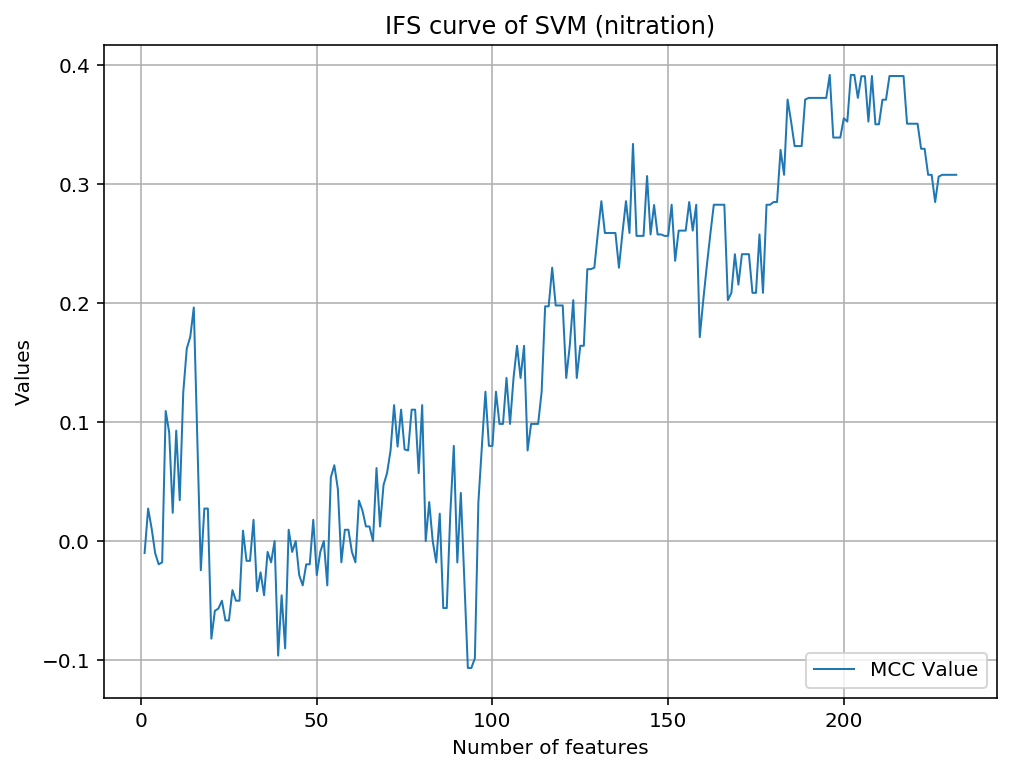

In [86]:
x_ = np.linspace(1, X_cat.shape[1], X_cat.shape[1])
plt.figure(figsize=(8, 6))
plt.plot(x_, mcc_svm, label='MCC Value', lw=1)
plt.xlabel('Number of features')
plt.ylabel('Values')
plt.title('IFS curve of SVM (nitration)')
plt.legend(loc="lower right")
plt.grid(True)

In [87]:
np.argmax(mcc_svm)

195

In [88]:
np.max(mcc_svm)

0.39199587526683394

### 采用 XGBoost 进行特征选取

In [129]:
sum_y = np.asarray(np.unique(y.astype(int), return_counts=True))

In [133]:
sum_y

array([[  0,   1],
       [ 53, 159]], dtype=int64)

In [135]:
# scale_pos_weight 参数调整适应非平衡数据
clf_xgb = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, scale_pos_weight=3)

In [140]:
clf_xgb.fit(X_new, y_new)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=None,
              silent=None, subsample=1, verbosity=1)

In [141]:
model_xgb = SelectFromModel(clf_xgb, prefit=True)

In [142]:
X_xgb = model_xgb.transform(X_new)

In [143]:
X_xgb.shape

(212, 163)

In [144]:
# 获取重要特征的排序（降序）
f_xgb_idxs = np.argsort(-clf_xgb.feature_importances_)[0:163]

In [145]:
# 获取对应的特征名称 TOP 20
f_name[f_xgb_idxs[0:20]]

array(['Site1_PSSM_M', 'Site13_AA_Factor_4', 'Site14_PSSM_M',
       'Site6_AA_15', 'Site20_AA_Factor_5', 'Site1_AA_Factor_2',
       'Site15_AA_12', 'Site20_PSSM_G', 'Site15_PSSM_N', 'Site1_Disorder',
       'Site8_PSSM_L', 'Site17_AA_Factor_4', 'Site13_PSSM_P',
       'Site13_AA_Factor_1', 'Site16_PSSM_N', 'Site4_Disorder',
       'Site15_PSSM_L', 'Site6_PSSM_E', 'Site3_AA_Factor_1',
       'Site9_PSSM_D'], dtype=object)

In [146]:
f_xgb_idxs[0:20]

array([ 33, 904, 293, 555, 940, 842, 732, 408, 303,   0, 171, 924, 275,
       901, 323,   3, 311, 127, 851, 184], dtype=int64)

In [168]:
# SVM 验证 IFS
y_pred_svm_list = list()

In [169]:
%%time
# IFS curve
clf_svm = SVC(C=1, kernel='sigmoid', random_state=0)
for i in range(0, X_xgb.shape[1]):
    y_pred_svm_list.append(cross_val_predict(clf_svm, X_xgb[:, 0:i+1], y_new, cv=10, n_jobs=-1))

Wall time: 9.38 s


In [170]:
mcc_svm = list()
acc_svm = list()
for i in range(0, X_xgb.shape[1]):
    mcc_svm.append(matthews_corrcoef(y_new, y_pred_svm_list[i]))
    acc_svm.append(accuracy_score(y_new, y_pred_svm_list[i]))

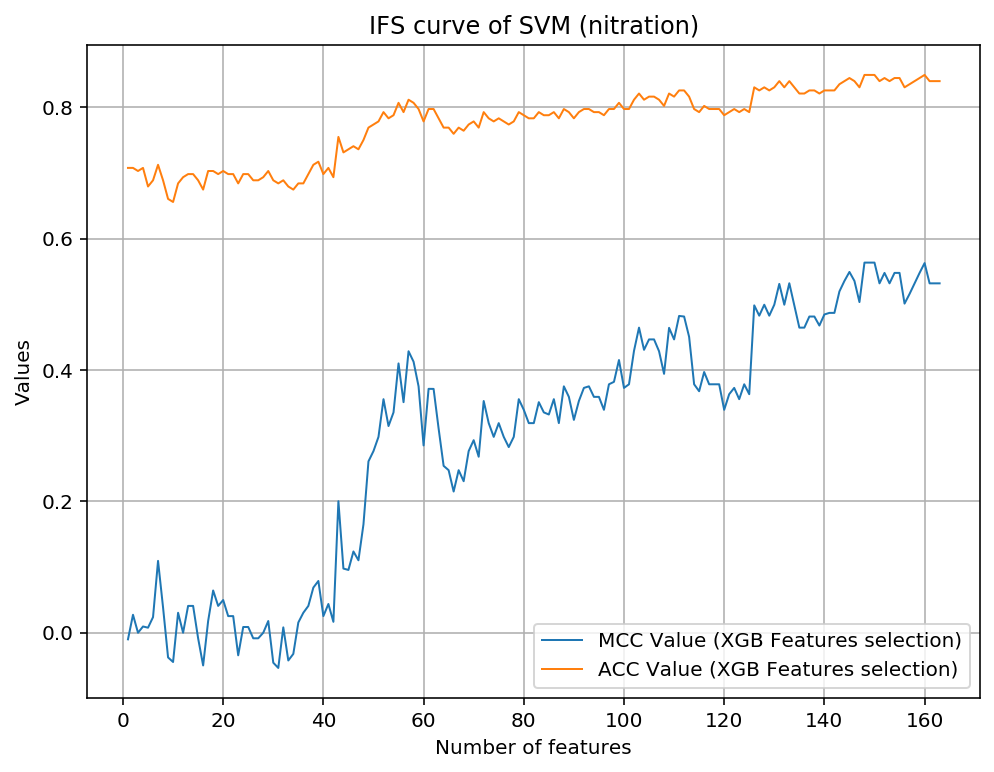

In [171]:
x_ = np.linspace(1, X_xgb.shape[1], X_xgb.shape[1])
plt.figure(figsize=(8, 6))
plt.plot(x_, mcc_svm, label='MCC Value (XGB Features selection)', lw=1)
plt.plot(x_, acc_svm, label='ACC Value (XGB Features selection)', lw=1)
plt.xlabel('Number of features')
plt.ylabel('Values')
plt.title('IFS curve of SVM (nitration)')
plt.legend(loc="lower right")
plt.grid(True)

In [172]:
print('MCC Max', np.argmax(mcc_svm), np.max(mcc_svm))

MCC Max 147 0.5634003995006042


In [173]:
print('ACC Max', np.argmax(acc_svm), np.max(acc_svm))

ACC Max 147 0.8490566037735849


In [179]:
# 网格搜索 148 dim 最佳参数

In [212]:
parameters_lgb = {'random_state':np.arange(0, 100)}
clf_lgb = lgb.LGBMClassifier(n_estimators=100, n_jobs=-1)

In [213]:
clf_grid_lgb = GridSearchCV(clf_lgb, parameters_lgb, cv=10, iid=False, scoring=make_scorer(matthews_corrcoef), n_jobs=-1, verbose=1)

In [214]:
%%time
clf_grid_lgb.fit(X_xgb[:, 0:148], y_new)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   29.1s


Wall time: 33.4 s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   33.3s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lamb...
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78

In [216]:
clf_grid_lgb.best_params_

{'random_state': 0}

In [217]:
clf_grid_lgb.best_score_

0.5205460290521863

In [153]:
# 对比941维的IFS (SVM)
y_pred_svm_list = list()

In [154]:
%%time
# IFS curve
clf_svm = SVC(C=1, kernel='sigmoid', random_state=0)
for i in range(0, X_new.shape[1]):
    y_pred_svm_list.append(cross_val_predict(clf_svm, X_new[:, 0:i+1], y_new, cv=10, n_jobs=-1))

Wall time: 2min 6s


In [156]:
mcc_svm = list()
for i in range(0, X_new.shape[1]):
    mcc_svm.append(matthews_corrcoef(y_new, y_pred_svm_list[i]))

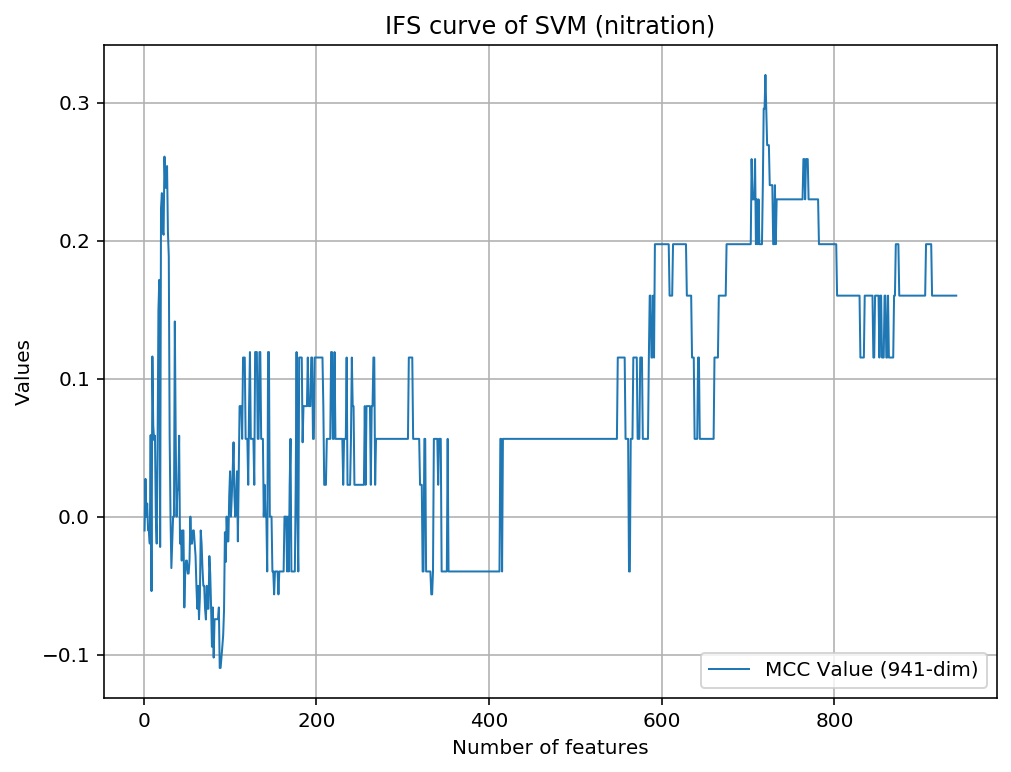

In [157]:
x_ = np.linspace(1, X_new.shape[1], X_new.shape[1])
plt.figure(figsize=(8, 6))
plt.plot(x_, mcc_svm, label='MCC Value (941-dim)', lw=1)
plt.xlabel('Number of features')
plt.ylabel('Values')
plt.title('IFS curve of SVM (nitration)')
plt.legend(loc="lower right")
plt.grid(True)

In [158]:
np.argmax(mcc_svm)

719

In [159]:
np.max(mcc_svm)

0.32006096980144877

In [160]:
%%time
# 对比941维的IFS (Random Forest)
y_pred_rf_list = list()

# IFS curve
clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
for i in range(0, X_new.shape[1]):
    y_pred_rf_list.append(cross_val_predict(clf_rf, X_new[:, 0:i+1], y_new, cv=10, n_jobs=-1))

mcc_rf = list()
for i in range(0, X_new.shape[1]):
    mcc_rf.append(matthews_corrcoef(y_new, y_pred_rf_list[i]))

Wall time: 15min 32s


In [174]:
acc_rf = list()
for i in range(0, X_new.shape[1]):
    acc_rf.append(accuracy_score(y_new, y_pred_rf_list[i]))

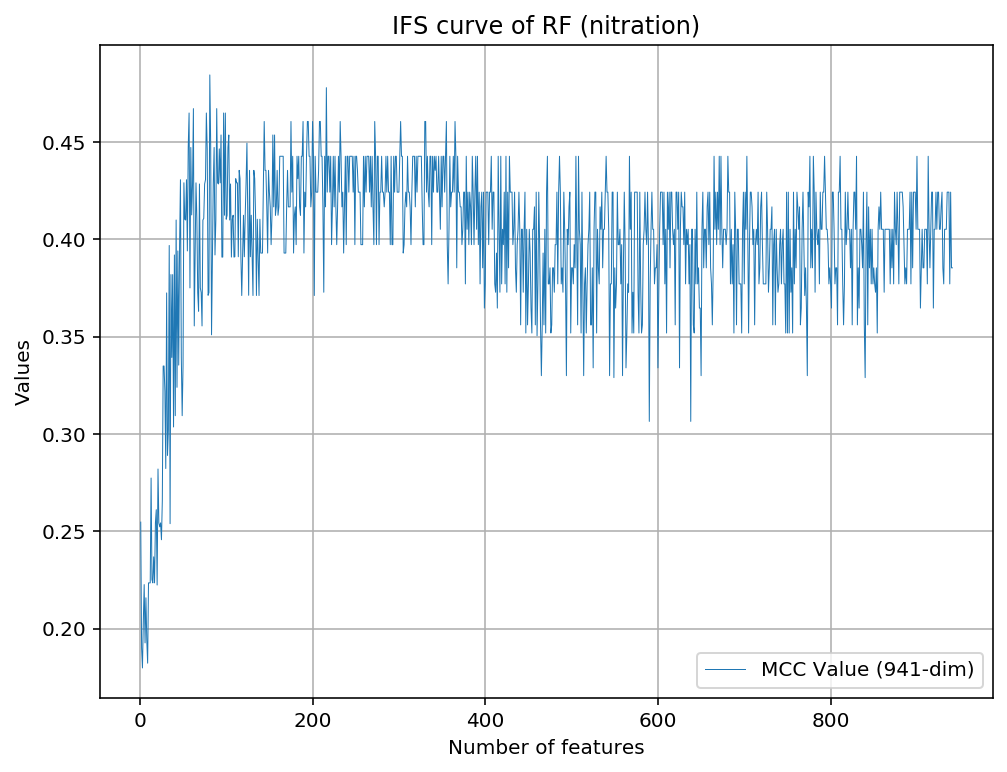

In [176]:
x_ = np.linspace(1, X_new.shape[1], X_new.shape[1])
plt.figure(figsize=(8, 6))
plt.plot(x_, mcc_rf, label='MCC Value (941-dim)', lw=0.5)
# plt.plot(x_, acc_rf, label='ACC Value (941-dim)', lw=0.5)
plt.xlabel('Number of features')
plt.ylabel('Values')
plt.title('IFS curve of RF (nitration)')
plt.legend(loc="lower right")
plt.grid(True)

In [177]:
print('MCC Max:', np.argmax(mcc_rf), np.max(mcc_rf))

MCC Max: 80 0.4844813951249545


In [178]:
print('ACC Max:', np.argmax(acc_rf), np.max(acc_rf))

ACC Max: 80 0.8254716981132075


### 按特征权重高低降序排列 IFS Curve

In [241]:
# 获取重要特征的排序（降序）
f_xgb_idxs_941 = np.argsort(-clf_xgb.feature_importances_)

In [242]:
%%time
y_pred_svm_list = list()

# IFS curve
clf_svm = SVC(C=1, random_state=0, kernel='sigmoid')
for i in range(0, X_new.shape[1]):
    y_pred_svm_list.append(cross_val_predict(clf_svm, X_new[:, f_xgb_idxs_941[0:i+1]], y_new, cv=10, n_jobs=-1))

mcc_svm = list()
acc_svm = list()
for i in range(0, X_new.shape[1]):
    mcc_svm.append(matthews_corrcoef(y_new, y_pred_svm_list[i]))
    acc_svm.append(accuracy_score(y_new, y_pred_svm_list[i]))

Wall time: 2min 20s


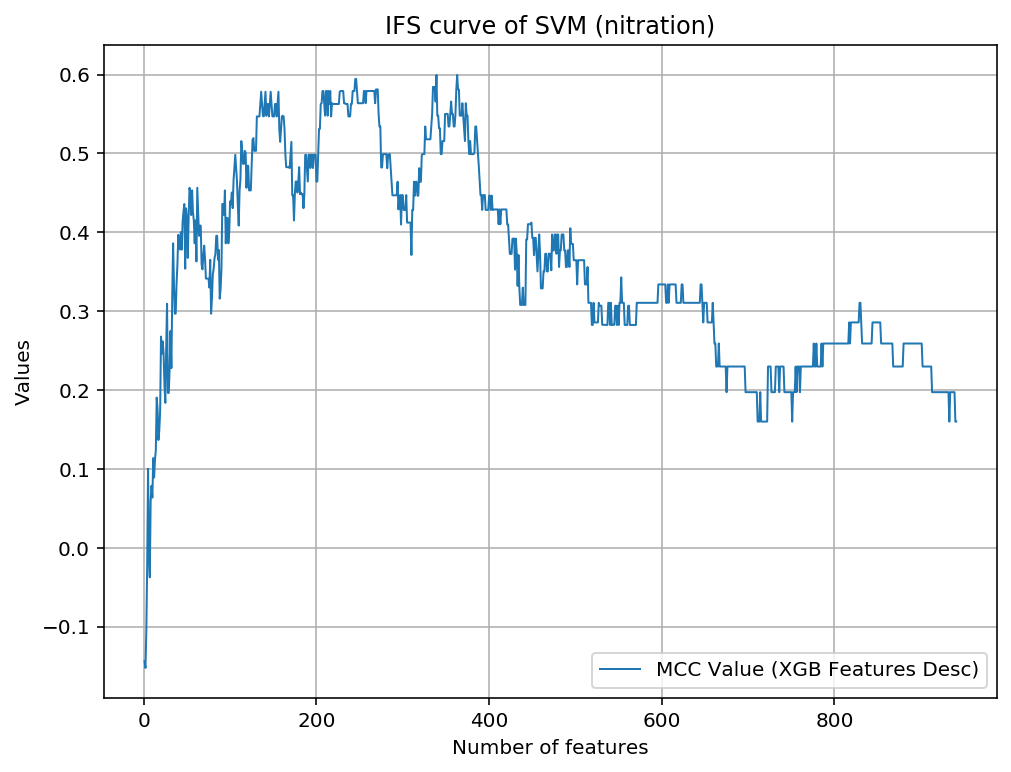

In [243]:
x_ = np.linspace(1, X_new.shape[1], X_new.shape[1])
plt.figure(figsize=(8, 6))
plt.plot(x_, mcc_svm, label='MCC Value (XGB Features Desc)', lw=1)
plt.xlabel('Number of features')
plt.ylabel('Values')
plt.title('IFS curve of SVM (nitration)')
plt.legend(loc="lower right")
plt.grid(True)

In [244]:
print('MCC Max:', np.argmax(mcc_svm), np.max(mcc_svm))

MCC Max: 338 0.5995244699074637


In [264]:
df_svm_mcc_941 = pd.DataFrame(data={'MCC':mcc_svm, 'Dims':np.arange(1, 942)})

In [270]:
df_svm_mcc_941.sort_values(by='MCC', ascending=False).to_csv('svm_mcc_941_des.csv', index_label='ID')

### 单变量特征选择

In [271]:
from sklearn.feature_selection import SelectKBest

In [272]:
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif

In [323]:
%%time
# 选取 TOP 100
model_f1 = SelectKBest(f_classif, k=100).fit(X_new, y_new)

Wall time: 8.98 ms


D:\dev\Miniconda3\envs\dl\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [459 522 659 759] are constant.
  UserWarning)
D:\dev\Miniconda3\envs\dl\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [324]:
# 降序排列特征权重
f1_idxs = np.argsort(-model_f1.scores_)

In [325]:
# 获取TOP20特征名称
print(model_f1.scores_[f1_idxs[0:10]])
print(f_name[f1_idxs[0:10]])

[13.23522951 12.97752809 12.97752809 12.26996083 12.26865338 11.58243038
 11.57351217 10.22684885 10.05224132  9.6737693 ]
['Site2_PSSM_L' 'Site6_AA_15' 'Site15_AA_12' 'Site7_PSSM_P' 'Site6_PSSM_R'
 'Site20_PSSM_N' 'Site2_PSSM_I' 'Site14_AA_Factor_1' 'Site6_AA_Factor_5'
 'Site20_PSSM_K']


In [337]:
# ANOVA 特征排序 IFS Curve
import seaborn as sns

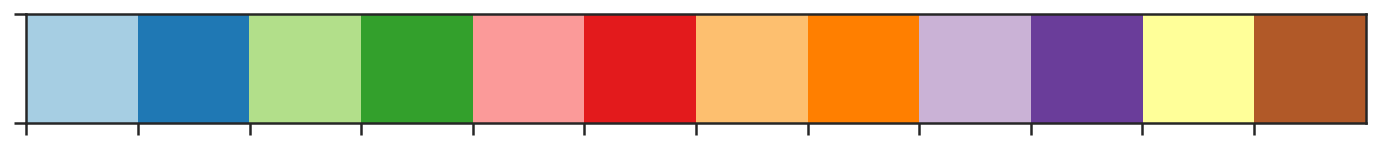

In [368]:
sns.set(style="ticks")
sns.palplot(sns.color_palette("Paired"))

In [359]:
%%time
y_pred_svm_list = list()

# IFS curve
clf_svm = SVC(C=1, random_state=0, kernel='sigmoid')
for i in range(0, X_new.shape[1]):
    y_pred_svm_list.append(cross_val_predict(clf_svm, X_new[:, f1_idxs[0:i+1]], y_new, cv=10, n_jobs=-1))

mcc_svm = list()
acc_svm = list()
for i in range(0, X_new.shape[1]):
    mcc_svm.append(matthews_corrcoef(y_new, y_pred_svm_list[i]))
    acc_svm.append(accuracy_score(y_new, y_pred_svm_list[i]))

Wall time: 2min 15s


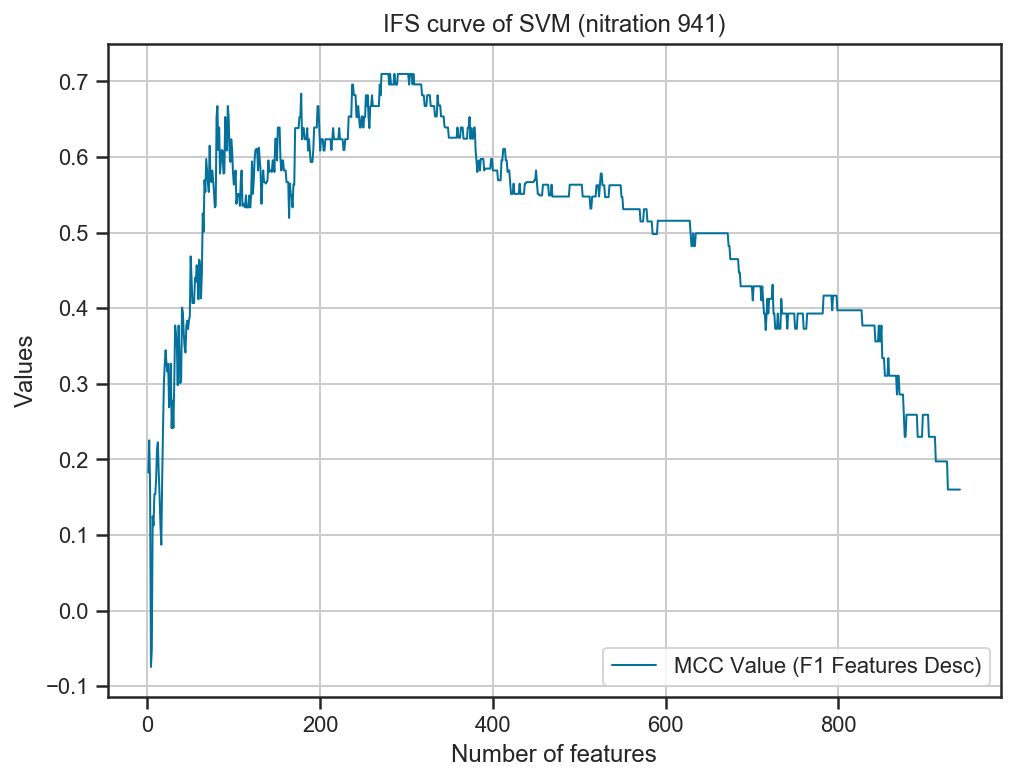

In [369]:
x_ = np.linspace(1, X_new.shape[1], X_new.shape[1])
plt.figure(figsize=(8, 6))
# plt.plot(x_, mcc_svm, label='MCC Value (F1 Features Desc)', lw=1)
sns.lineplot(x=x_, y=mcc_svm, label='MCC Value (F1 Features Desc)', lw=1, color='#03719c')
plt.xlabel('Number of features')
plt.ylabel('Values')
plt.title('IFS curve of SVM (nitration 941)')
plt.legend(loc="lower right")
plt.grid(True)

In [329]:
print('MCC Max:', np.argmax(mcc_svm), np.max(mcc_svm))

MCC Max: 270 0.7099134286879011


In [321]:
df_svm_mcc_anova_941 = pd.DataFrame(data={'MCC':mcc_svm, 'Dims':np.arange(1, 942)})

In [322]:
df_svm_mcc_anova_941.sort_values(by='MCC', ascending=False).to_csv('svm_mcc_anova_941_des.csv', index_label='ID')

In [399]:
%%time
# LGB F1 IFS Curve
y_pred_lgb_list = list()

# IFS curve
clf_lgb = lgb.LGBMClassifier(n_estimators=100, boosting_type='gbdt', n_jobs=-1)
for i in range(0, X_new.shape[1]):
    y_pred_lgb_list.append(cross_val_predict(clf_lgb, X_new[:, f1_idxs[0:i+1]], y_new, cv=10, n_jobs=-1))

mcc_lgb = list()
acc_lgb = list()
for i in range(0, X_new.shape[1]):
    mcc_lgb.append(matthews_corrcoef(y_new, y_pred_lgb_list[i]))
    acc_lgb.append(accuracy_score(y_new, y_pred_lgb_list[i]))

Wall time: 10min 24s


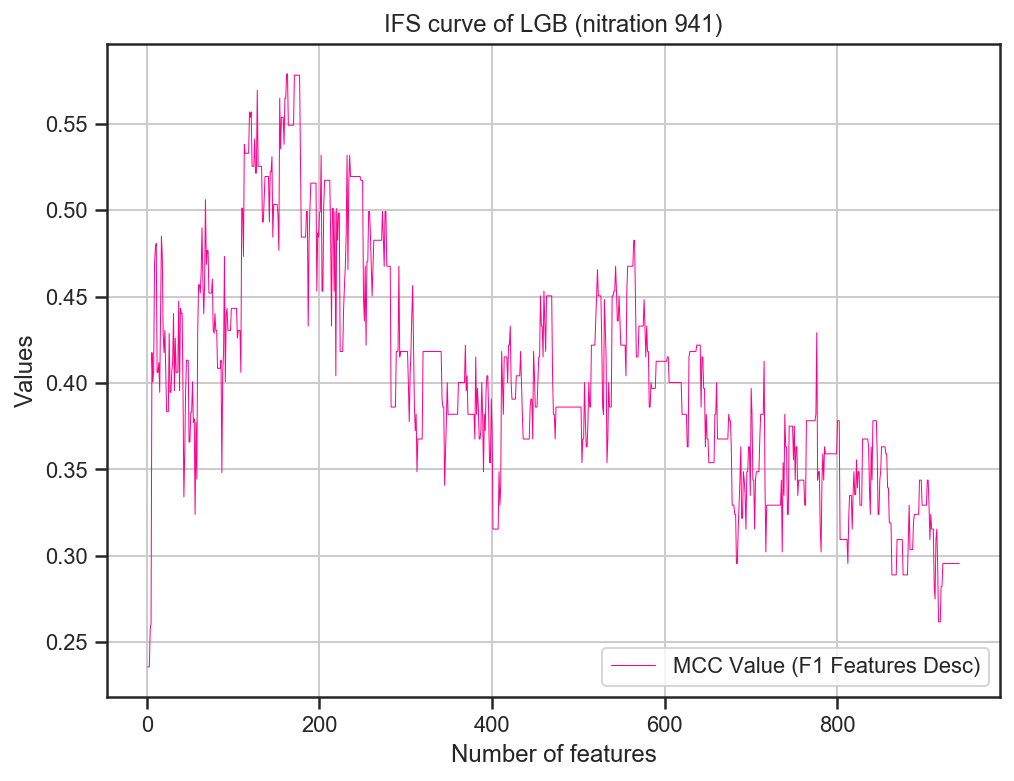

In [400]:
x_ = np.linspace(1, X_new.shape[1], X_new.shape[1])
plt.figure(figsize=(8, 6))
# plt.plot(x_, mcc_svm, label='MCC Value (F1 Features Desc)', lw=1)
sns.lineplot(x=x_, y=mcc_lgb, label='MCC Value (F1 Features Desc)', lw=0.5, color='#ff028d')
plt.xlabel('Number of features')
plt.ylabel('Values')
plt.title('IFS curve of LGB (nitration 941)')
plt.legend(loc="lower right")
plt.grid(True)

In [401]:
print('MCC Max:', np.argmax(mcc_lgb), np.max(mcc_lgb))

MCC Max: 161 0.578874628989079


In [402]:
df_lgb_gbdt_mcc_anova_941 = pd.DataFrame(data={'MCC':mcc_lgb, 'Dims':np.arange(1, 942)})

In [403]:
df_lgb_gbdt_mcc_anova_941.sort_values(by='MCC', ascending=False).to_csv('lgb_gbdt_mcc_anova_941_des.csv', index_label='ID')